In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tflite_support import metadata as _metadata

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers

## Prepare training and validation datasets

In [2]:
epochs=50
batch_size = 80
img_height = 180
img_width = 180
image_shape = (img_height, img_width, 3)

directory = "IMAGES"

log_root = "logs"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123
)

steps_per_epoch = len(train_ds)
num_classes = len(train_ds.class_names)

Found 900 files belonging to 6 classes.
Using 720 files for training.
Found 900 files belonging to 6 classes.
Using 180 files for validation.


In [3]:
class_names = train_ds.class_names

print("Class names: " + str(class_names))
with open("labelmap.txt", "w") as f:
    for c in class_names:
        f.write(c)
        f.write('\n')

Class names: ['1', '10', '2', '20', '5', '50']


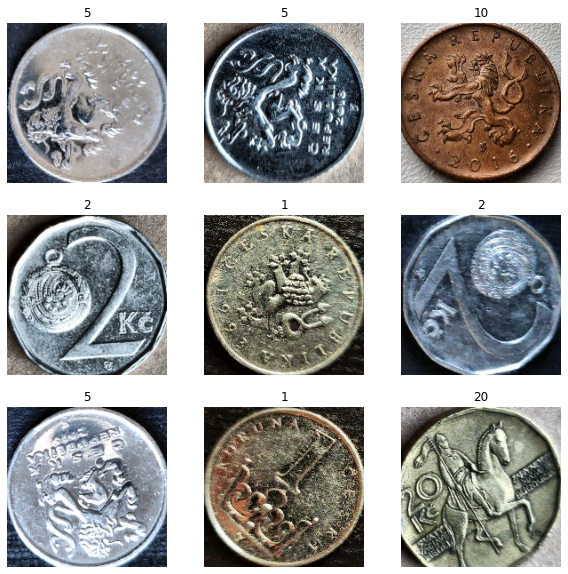

In [4]:
images, labels = next(iter(train_ds.skip(3).take(1)))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Optimize the dataset for performance

`Dataset.cache()` - to keep the images in memory after they're loaded off disk during the first epoch

`Dataset.prefetch()` - overlaps data preprocessing and model execution while training

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data preprocessing

In [6]:
# [0, 255] -> [0, 1]
preprocessing_layer = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=image_shape),
])

## Data augmentation visualization

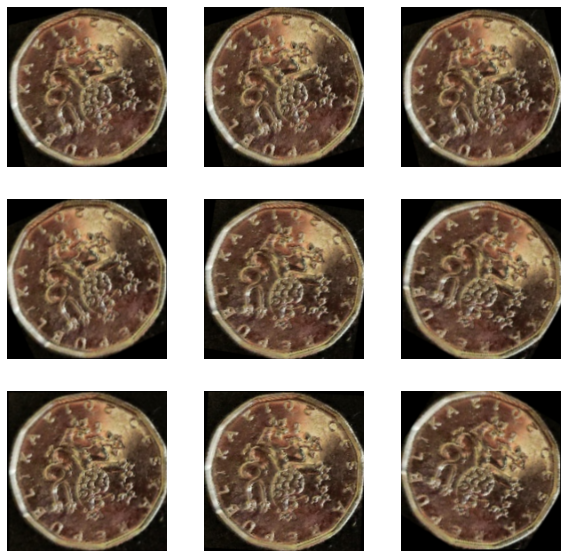

In [7]:
data_augmentation_layer = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomRotation(0.1, fill_mode='constant'),
        #layers.experimental.preprocessing.RandomZoom(0.01, fill_mode='constant'),
        #layers.experimental.preprocessing.RandomTranslation(0.01, 0.01, fill_mode='constant'),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation_layer(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Callbacks

In [8]:
# avoid overlearning
class stop_learning_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

def learning_rate_schedule(epoch):
    if epoch < epochs//2:
        return 1e-3
    
    if epoch < 2*epochs//3:
        return 1e-4
    
    return 1e-5
    
# adjust learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule)

def get_callbacks(model):
    # TensorBoard callback
    timestamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    logdir = os.path.join(log_root, f'{model.name}_{timestamp}')
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    return [lr_schedule, tensorboard_callback, stop_learning_callback()]

## Train model

In [9]:
def train_model(model, 
                batch_size=batch_size, 
                n_epochs=epochs,  
                optimizer=keras.optimizers.Adam, 
                learning_rate=0.001):
    
    opt = optimizer(lr=learning_rate)
    model.compile(optimizer=opt, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=n_epochs,
        verbose=1,
        callbacks=get_callbacks(model)
    )
    
    
def show_summary(model):
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()

## 4-layered CNN

In [10]:
cnn = Sequential([
    preprocessing_layer,
    
    data_augmentation_layer,
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    
    layers.Dropout(0.5),
    
    layers.Flatten(),
    
    layers.Dense(num_classes, activation='softmax')],
    
    name = 'CNN_layers_4'
)

show_summary(cnn)

train_model(cnn)

Model: "CNN_layers_4_rotation_zoom_translation_epochs_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D) 

9/9 [==============================] - 11s 1s/step - loss: 0.0856 - accuracy: 0.9681 - val_loss: 0.4902 - val_accuracy: 0.8444
Epoch 43/50
9/9 [==============================] - 11s 1s/step - loss: 0.0816 - accuracy: 0.9792 - val_loss: 0.4983 - val_accuracy: 0.8444
Epoch 44/50
9/9 [==============================] - 13s 1s/step - loss: 0.0841 - accuracy: 0.9667 - val_loss: 0.5076 - val_accuracy: 0.8444
Epoch 45/50
9/9 [==============================] - 13s 1s/step - loss: 0.0779 - accuracy: 0.9764 - val_loss: 0.5094 - val_accuracy: 0.8444
Epoch 46/50
9/9 [==============================] - 12s 1s/step - loss: 0.0745 - accuracy: 0.9806 - val_loss: 0.5050 - val_accuracy: 0.8444
Epoch 47/50
9/9 [==============================] - 12s 1s/step - loss: 0.0762 - accuracy: 0.9764 - val_loss: 0.5120 - val_accuracy: 0.8444
Epoch 48/50
9/9 [==============================] - 12s 1s/step - loss: 0.0852 - accuracy: 0.9708 - val_loss: 0.4934 - val_accuracy: 0.8444
Epoch 49/50
9/9 [======================

## Predict on new data

Predicted: 2 with a 87.72% confidence.
Correct: 2


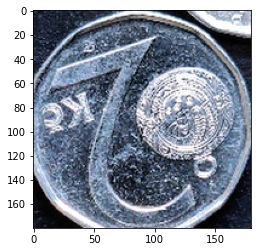

In [21]:
import random

class_num = 2
model = cnn

# get image path
img_dir_path = directory + "/" + str(class_names[class_num])
img_dir = [f for f in os.listdir(img_dir_path) if os.path.isfile(img_dir_path + "/" + f)]
img_name = img_dir[random.randint(0, len(img_dir)-1)]
img_path = img_dir_path + "/" + img_name

# load image
img = keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array_batch = tf.expand_dims(img_array, 0) # Create a batch

# predict
predictions = model.predict(img_array_batch)

#print(predictions)

# show results
plt.imshow(img_array/255)

print(
    "Predicted: {} with a {:.2f}% confidence."
    .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
)

print("Correct: " + str(class_names[class_num]))

## Export to .tflite

In [12]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpizsx_dd9/assets
